# Script to evaluate the python implementations of the Zoltan Donko Code EduPIC

In [143]:
%matplotlib inline
import numpy as np
import re
from scipy.optimize import curve_fit
from scipy.stats import chi2
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.colors import Normalize
from decimal import Decimal
from tqdm import tqdm
import sys,os

plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'text.color' : "k",
                     'axes.labelcolor' : "k"})
plt.rcParams["font.family"]='serif'
plt.rcParams["figure.facecolor"] = 'w'

plt.rcParams["figure.figsize"] = 8,4
plt.rcParams["figure.dpi"] = 200
plt.rcParams['text.usetex'] = False
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg')

def format_e(n):
    a = '%e' % Decimal(n)
    return a.split('e')[0].rstrip('0').rstrip('.')+'e'+a.split('e')[1]

# Example: Script to parse info.txt for L and FREQUENCY
import re

def parse_info_file(filepath):
    params = {}
    try:
        with open(filepath, 'r') as f:
            for line in f:
                line = line.strip()
                if "Gap distance" in line:
                    match = re.search(r"=\s*([0-9.eE+-]+)", line)
                    if match:
                        params['L'] = float(match.group(1))
                elif "Frequency" in line and "Plasma frequency" not in line: # Avoid Plasma Frequency
                    match = re.search(r"=\s*([0-9.eE+-]+)", line)
                    if match:
                        params['FREQUENCY'] = float(match.group(1))
                elif "# of grid divisions" in line:
                    match = re.search(r"=\s*(\d+)", line)
                    if match:
                        params['N_G'] = int(match.group(1))
                elif "# of time steps / period" in line: # This is N_T
                    match = re.search(r"=\s*(\d+)", line)
                    if match:
                        params['N_T'] = int(match.group(1))
                elif "# of time steps binned for the XT distributions" in line: # You'd need to add this to info.txt
                     match = re.search(r"=\s*(\d+)", line)
                     if match:
                         params['N_BIN'] = int(match.group(1))

    except FileNotFoundError:
        print(f"Error: Info file not found at {filepath}")
        return None

    if 'FREQUENCY' in params:
        params['PERIOD'] = 1.0 / params['FREQUENCY']
    if 'N_T' in params and 'N_BIN' in params:
        params['N_XT'] = params['N_T'] // params['N_BIN']
    if 'L' in params and 'N_G' in params:
        params['DX'] = params['L'] / (params['N_G'] -1)

    return params

path = 'results/atta1/'
simulation_params = parse_info_file(path+'info.txt')

if simulation_params:
    L_val = simulation_params.get('L')
    PERIOD_val = simulation_params.get('PERIOD')
    N_G_val = simulation_params.get('N_G')
    N_XT_val = simulation_params.get('N_XT') # Calculated if N_T and N_BIN are found
    DX_val = simulation_params.get('DX')

    print(f"L: {L_val}, PERIOD: {PERIOD_val}, N_G: {N_G_val}, N_XT: {N_XT_val}, DX: {DX_val}")


Error: Info file not found at results/atta1/info.txt


## Testing Convergence

(15001, 3)


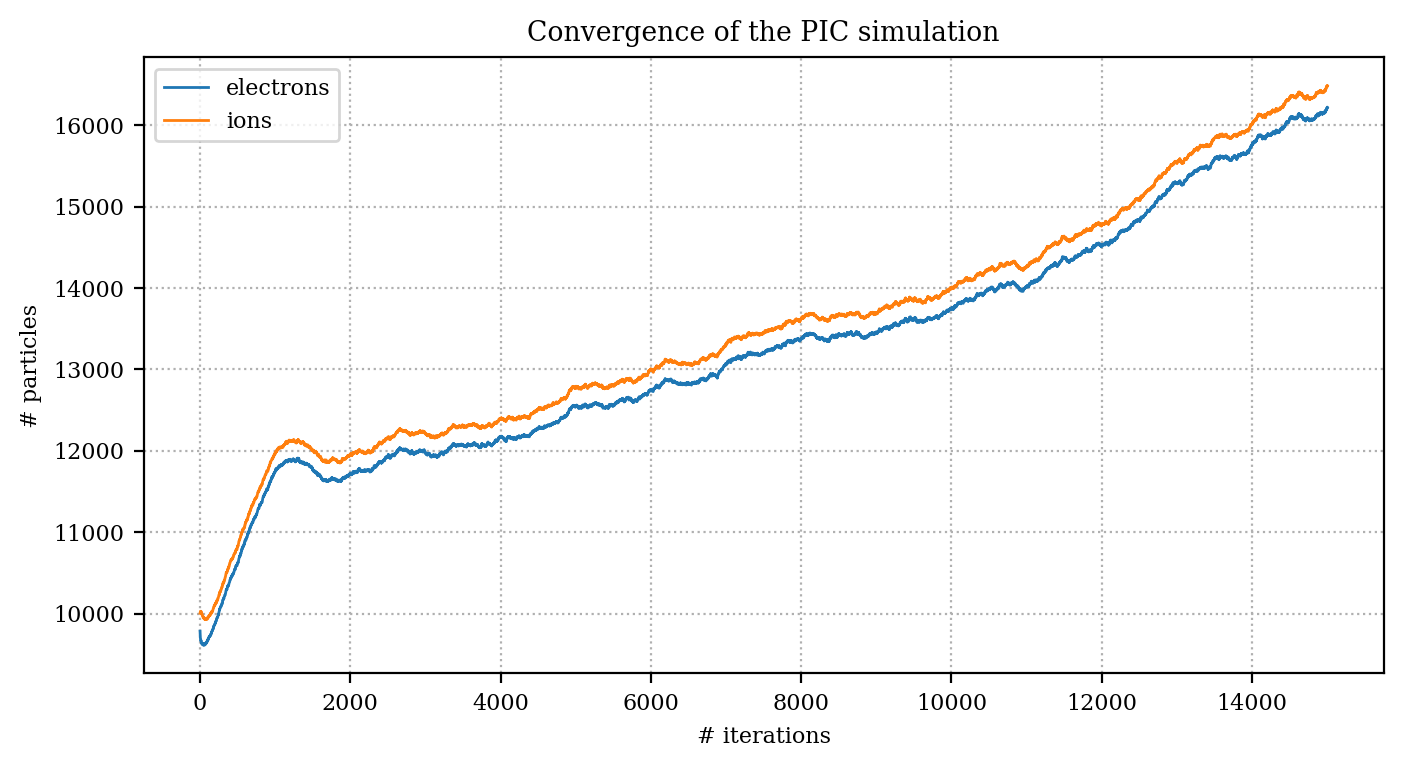

In [144]:
conv = np.loadtxt(path+'conv.dat')

t, Ne, Ni = conv.T
print(conv.shape)

def saturation(t,N_max,a):
    res = N_max*(1-np.exp(-a*(t-1))) + Ne[0] 
    return res

#popt_conv, pcov_conv = curve_fit(saturation,t,Ne,p0=[1,0.1])
#N_max, a_conv = popt_conv[0], popt_conv[1]
#dN_max, da_conv = np.sqrt(np.diag(pcov_conv))[0], np.sqrt(np.diag(pcov_conv))[0]

plt.title('Convergence of the PIC simulation')
plt.plot(t,Ne,label='electrons',lw=1)
plt.plot(t,Ni,label='ions',lw=1)
#plt.plot(t, saturation(t,N_max,a_conv),label='conversion Fit \n$N_{max} =$ %i $\\pm$ %i \n$\\alpha =$ %.2e $\\pm$ %.2e'%(int(N_max),int(dN_max), a_conv, da_conv))
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('# iterations')
plt.ylabel('# particles')
plt.grid(which='major',ls=':')
plt.grid(which='minor',ls=':',alpha=.5,lw='.5')
plt.legend(loc='best')
plt.show()

In [40]:
print('volatility of population = %.3f'%(dN_max/N_max*100),'%')
print('Steady state reached to %.2f'%(100-(np.abs(np.mean(Ne[-100:-1])-N_max)/N_max)*100),'%')

NameError: name 'dN_max' is not defined

## Particle densities of ions and electrons

In [41]:
density = np.loadtxt(path+'density.dat')

x, ne, ni = density.T

plt.title('particle density distributions')
plt.plot(x*1e2,ne,label='electrons')
plt.plot(x*1e2,ni,label='ions')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('position $x$ [cm]')
plt.ylabel('particle density $n$ [cm$^{-3}$]')
plt.grid(which='major',ls=':')
plt.grid(which='minor',ls=':',alpha=.5,lw='.5')
plt.legend(loc='best')
plt.show()

FileNotFoundError: results/atta/density.dat not found.

## Electron Energy Distribution function

In [42]:
EEPF = np.loadtxt(path+'eepf.dat')
EEPF.shape

energy, ge = EEPF[:1200].T

# Define the Maxwellian function for fitting
def maxwellian(E, Te):
    A =   2 * Te ** (-3 / 2) * np.sqrt(E / np.pi)
    res = A * np.exp(-E / Te)
    return res
    
# Define the Maxwellian_line function for fitting
def maxwellian_line(E,Te):
    A =   2 * Te ** (-3 / 2) * np.sqrt(E / np.pi)
    res = -E/Te
    return res

# Define the Maxwellian function for fitting
def log_maxwellian(E, Te):
    res = 2 * Te ** (-3 / 2) * np.sqrt(E / np.pi) * np.exp(-E / Te)
    return np.log(res+1e-30)

popt_line,pcov_line = curve_fit(maxwellian_line,energy[:],np.log(ge[:]+1e-30))
temperature = popt_line[0]
error = np.sqrt(np.diag(pcov_line))[0]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,3))

# Regular plot (left side)
ax1.plot(energy, ge, label='PIC Distribution')
ax1.plot(energy, np.e**maxwellian_line(energy,popt_line[0]),ls='--' , label=f'Maxwellian line Fit \n (Te={temperature:.2f}±{error:.2f} eV)')
ax1.plot(energy, maxwellian(energy, popt_line[0])/np.sqrt(energy),ls='--',c='C2' , label=f'Maxwellian \n (Te={temperature:.2f}±{error:.2f} eV)')
ax1.set_xlabel('Energy $E$ [eV]')
ax1.set_ylabel('$g_e$ [eV$^{-3/2}$]')
ax1.set_title('Electron Energy Probability Function')
ax1.legend(loc='best',fontsize=5)
ax1.grid(which='major',ls=':')
ax1.set_xlim(0, min(10, energy.max()))

# Log plot (right side)
ax2.semilogy(energy, ge, label='PIC Distribution')
ax2.semilogy(energy, np.e**maxwellian_line(energy,popt_line[0]),ls='--' , label=f'Maxwellian line Fit \n (Te={temperature:.2f}±{error:.2f} eV)')
ax2.semilogy(energy, maxwellian(energy, popt_line[0])/np.sqrt(energy),ls='--',c='C2' , label=f'Maxwellian \n (Te={temperature:.2f}±{error:.2f} eV)')
ax2.set_xlabel('Energy $E$ [eV]')
ax2.set_ylabel('log($g_e$) [eV$^{-3/2}$]')
ax2.set_title('EEPF (Log Scale)')
ax2.legend(loc='lower left',fontsize=5)
ax2.grid(which='major',ls=':')
ax2.grid(which='minor',ls=':',alpha=.5)

ax2.set_xlim(0, min(100, energy.max()))  # Show more of the tail in log plot
ax2.set_ylim(1e-10,1e-0)

plt.tight_layout()
plt.show()

print(f"Fitted electron temperature: {temperature:.2f} ± {error:.2f} eV")

# Get the energy table and distribution function
distribution = ge*np.sqrt(energy)
dE,dE_err = np.mean(np.diff(energy)), np.std(np.diff(energy))
avg_E = np.sum(energy*distribution*dE)
eff_Te = 2/3*avg_E

# Perform the fitting manually instead of using the class method
try:
    popt_log, pcov_log = curve_fit(log_maxwellian,energy,np.log(distribution),p0=[.5])
    popt, pcov = curve_fit(maxwellian,energy,(distribution),p0=[.5])
    temperature = popt_log[0]
    error = np.sqrt(np.diag(pcov_log))[0]
    fitted_maxwellian = maxwellian(energy, temperature)
except Exception as e:
    print(f"Fitting error: {e}")
    temperature = 5.0  # Default value
    error = 0.0
# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,3))

# Regular plot (left side)
ax1.plot(energy, distribution, label='PIC Distribution')
# ax1.plot(energy, fitted_maxwellian,ls='--' , label=f'Maxwellian log_Fit \n (Te={temperature:.2f}±{error:.2f} eV)')
ax1.plot(energy, maxwellian(energy,eff_Te),ls='--',c='C2' , label=f'Maxwellian \n (Teff={eff_Te:.2f} eV)')
# ax1.plot(energy, maxwellian(energy,popt[0]),ls='--',c='C3' , label=f'Maxwellian_Fit \n (Te={popt[0]:.2f}±{np.sqrt(np.diag(pcov))[0]:.2f} eV)')

ax1.set_xlabel('Energy $E$ [eV]')
ax1.set_ylabel('$f_e$ [eV$^{-1}$]')
ax1.set_title('Electron Energy Distribution Function')
ax1.legend(loc='best',fontsize=5)
ax1.grid(which='major',ls=':')
ax1.set_xlim(0, min(20, energy.max()))

# Log plot (right side)
ax2.semilogy(energy, distribution, label='PIC Distribution')
# ax2.semilogy(energy, fitted_maxwellian,ls='--' , label=f'Maxwellian log_Fit \n (Te={temperature:.2f}±{error:.2f} eV)')
ax2.semilogy(energy, maxwellian(energy,eff_Te),ls='--',c='C2' , label=f'Maxwellian \n (Teff={eff_Te:.2f} eV)')
# ax2.semilogy(energy, maxwellian(energy,popt[0]),ls='--',c='C3' , label=f'Maxwellian_Fit \n (Te={popt[0]:.2f}±{np.sqrt(np.diag(pcov))[0]:.2f} eV)')

ax2.set_xlabel('Energy $E$ [eV]')
ax2.set_ylabel('log($f_e$) [eV$^{-1}$]')
ax2.set_title('EEDF (Log Scale)')
ax2.legend(loc='best',fontsize=5)
ax2.grid(which='major',ls=':')
ax2.grid(which='minor',ls=':',alpha=.5)

ax2.set_xlim(0, min(100, energy.max()))  # Show more of the tail in log plot
ax2.set_ylim(1e-10,1e-0)

plt.tight_layout()
plt.show()

print(f"Fitted electron temperature: {temperature:.2f} ± {error:.2f} eV")


FileNotFoundError: results/atta/eepf.dat not found.

In [ ]:
dE,dE_err = np.mean(np.diff(energy)), np.std(np.diff(energy))
print('checking for uniformly spaced energy values: \n dE =',dE,'±',dE_err)
print('checking for normalisation of the EEDF: \n ',np.sum(distribution*dE))

checking for uniformly spaced energy values: 
 dE = 0.05 ± 2.510635837256415e-15
checking for normalisation of the EEDF: 
  0.9999977653416803


2.4094452585434185 4.015646930135695


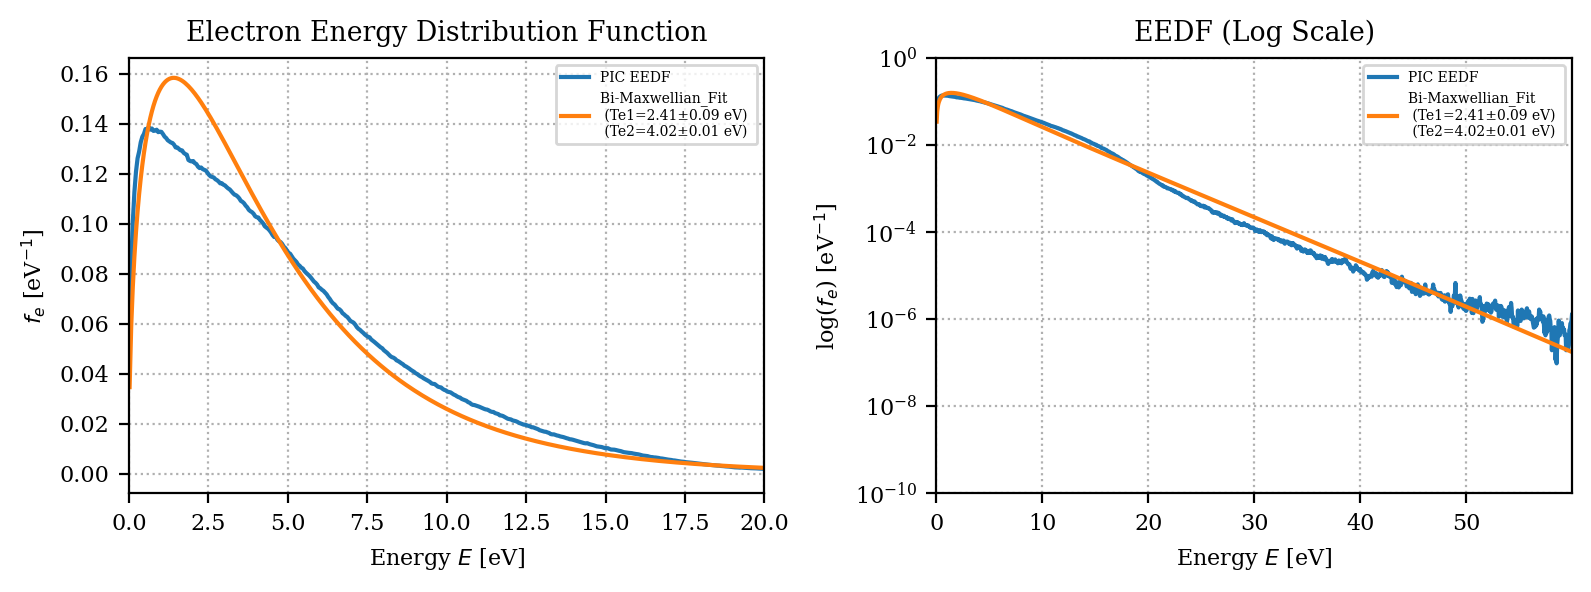

Fitted electron temperatures: 
 T_1 = 2.41 ± 0.09 eV  
 T_2 = 4.02 ± 0.01 eV


In [ ]:
def two_temp_maxwellian(E,T1,T2):
    res1 = 2 * T1 ** (-3 / 2) * np.sqrt(E / np.pi) * np.exp(-E / T1)
    res2 = 2 * T2 ** (-3 / 2) * np.sqrt(E / np.pi) * np.exp(-E / T2)
    return np.log((res1 + res2)/2)

popt,pcov = curve_fit(two_temp_maxwellian,energy,np.log(distribution),p0=[.5,2])
print(popt[0],popt[1])

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,3))

# Regular plot (left side)
ax1.plot(energy,distribution,label='PIC EEDF')
ax1.plot(energy,np.e**two_temp_maxwellian(energy,popt[0],popt[1]),
         label=f'Bi-Maxwellian_Fit \n (Te1={popt[0]:.2f}±{np.sqrt(np.diag(pcov))[0]:.2f} eV) \n (Te2={popt[1]:.2f}±{np.sqrt(np.diag(pcov))[1]:.2f} eV)')

ax1.set_xlabel('Energy $E$ [eV]')
ax1.set_ylabel('$f_e$ [eV$^{-1}$]')
ax1.set_title('Electron Energy Distribution Function')
ax1.legend(loc='best',fontsize=5)
ax1.grid(which='major',ls=':')
ax1.set_xlim(0, min(20, energy.max()))

# Log plot (right side)
ax2.semilogy(energy,distribution,label='PIC EEDF')
ax2.semilogy(energy,np.e**two_temp_maxwellian(energy,popt[0],popt[1]),
         label=f'Bi-Maxwellian_Fit \n (Te1={popt[0]:.2f}±{np.sqrt(np.diag(pcov))[0]:.2f} eV) \n (Te2={popt[1]:.2f}±{np.sqrt(np.diag(pcov))[1]:.2f} eV)')

ax2.set_xlabel('Energy $E$ [eV]')
ax2.set_ylabel('log($f_e$) [eV$^{-1}$]')
ax2.set_title('EEDF (Log Scale)')
ax2.legend(loc='best',fontsize=5)
ax2.grid(which='major',ls=':')
ax2.grid(which='minor',ls=':',alpha=.5)

ax2.set_xlim(0, min(100, energy.max()))  # Show more of the tail in log plot
ax2.set_ylim(1e-10,1e-0)

plt.tight_layout()
plt.show()

print(f"Fitted electron temperatures: \n T_1 = {popt[0]:.2f} ± {np.sqrt(np.diag(pcov))[0]:.2f} eV  \n T_2 = {popt[1]:.2f} ± {np.sqrt(np.diag(pcov))[1]:.2f} eV")

## Spatiotemporal evolution

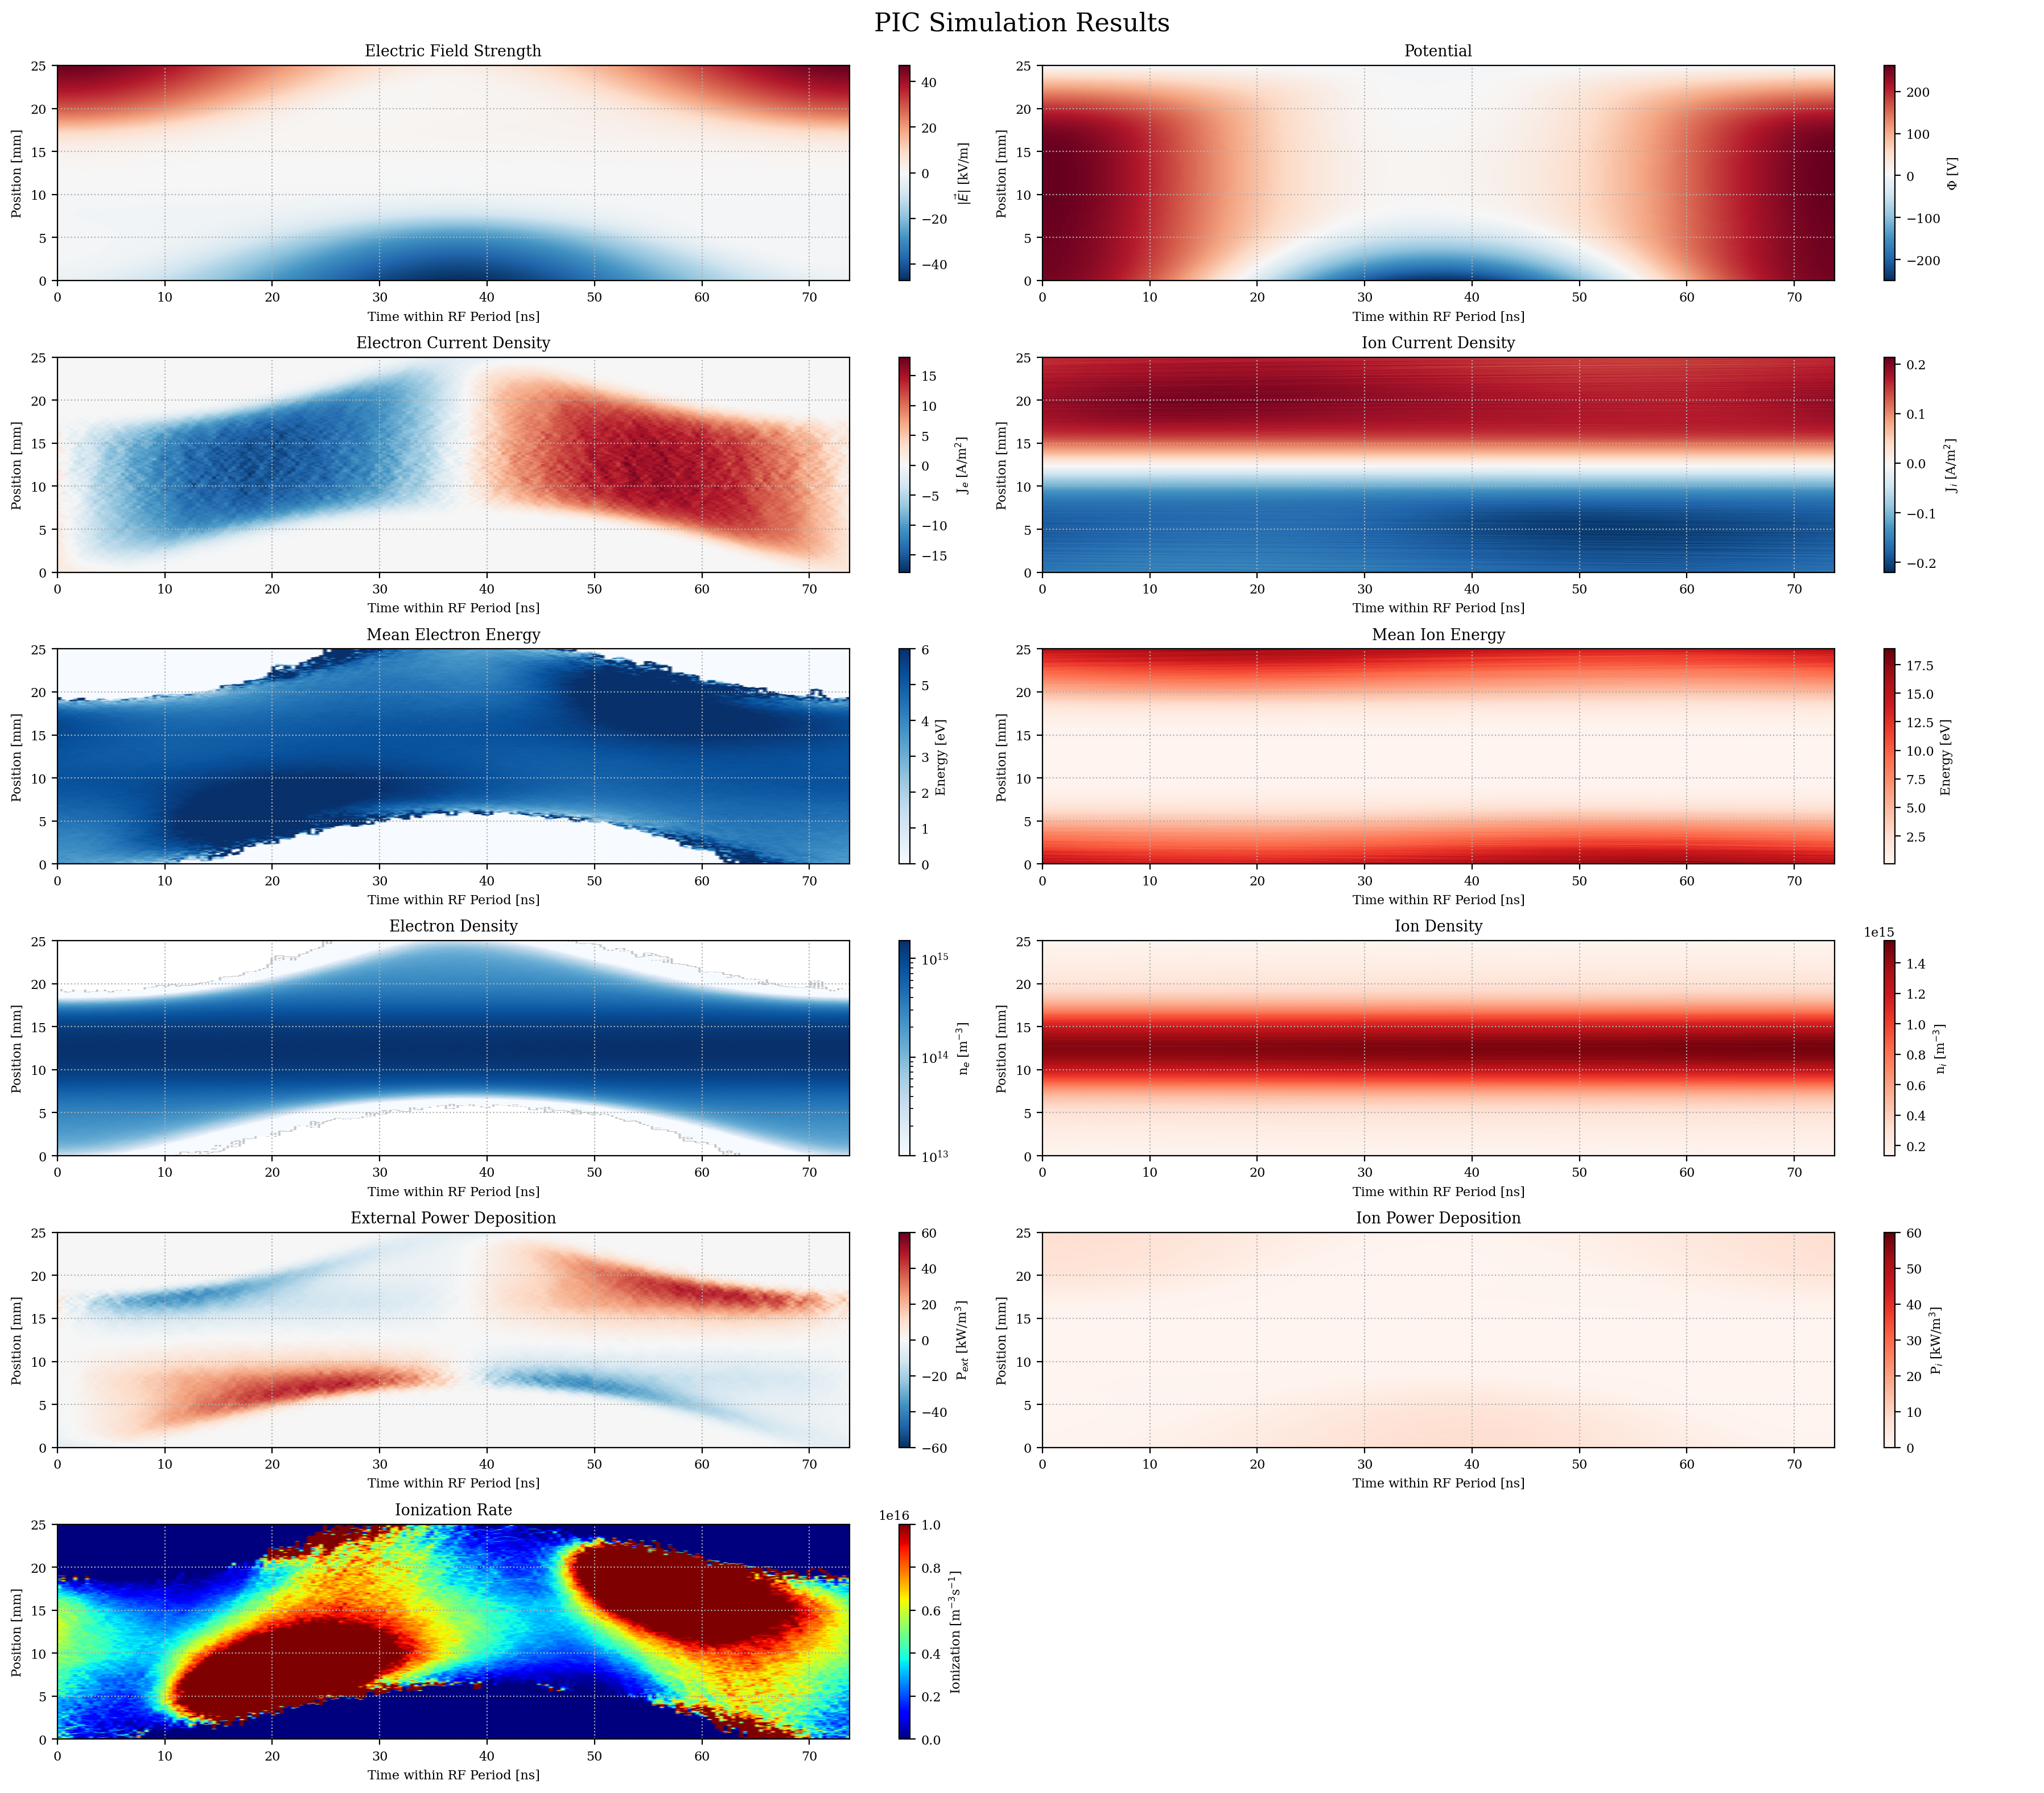

In [ ]:
import os

# Create figure with subplots - 4x3 grid to fit all 11 plots
fig, axes = plt.subplots(6, 2, figsize=(18, 16))
fig.tight_layout(pad=3.0)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Define the data files and their corresponding titles and color bar labels
data_info = [{'file': 'efield_xt.dat', 'title': 'Electric Field Strength', 'cbar': '|$\\vec{E}$| [kV/m]', 'scale': 1e-3, 'cmap': 'RdBu_r', 'lim':(None,None)},
    {'file': 'pot_xt.dat', 'title': 'Potential', 'cbar': 'Φ [V]', 'scale': 1.0, 'cmap': 'RdBu_r', 'lim':(None,None)},
    {'file': 'je_xt.dat', 'title': 'Electron Current Density', 'cbar': 'J$_e$ [A/m$^2$]', 'scale': 1.0, 'cmap': 'RdBu_r', 'lim':(None,None)},
    {'file': 'ji_xt.dat', 'title': 'Ion Current Density', 'cbar': 'J$_i$ [A/m$^2$]', 'scale': 1.0, 'cmap': 'RdBu_r', 'lim':(None,None)},
    {'file': 'meanee_xt.dat', 'title': 'Mean Electron Energy', 'cbar': 'Energy [eV]', 'scale': 1.0, 'cmap': 'Blues', 'lim':(0,6)},
    {'file': 'meanei_xt.dat', 'title': 'Mean Ion Energy', 'cbar': 'Energy [eV]', 'scale': 1.0, 'cmap': 'Reds', 'lim':(None,None)},
    {'file': 'ne_xt.dat', 'title': 'Electron Density', 'cbar': 'n$_e$ [m$^{-3}$]', 'scale': 1.0, 'cmap': 'Blues', 'log': True, 'lim':(1e13,None)},
    {'file': 'ni_xt.dat', 'title': 'Ion Density', 'cbar': 'n$_i$ [m$^{-3}$]', 'scale': 1.0, 'cmap': 'Reds', 'log': False, 'lim':(None,None)},
    {'file': 'powere_xt.dat', 'title': 'External Power Deposition', 'cbar': 'P$_{ext}$ [kW/m$^3$]', 'scale': 1e-3, 'cmap': 'RdBu_r', 'log': False, 'lim':(-60,60)},
    {'file': 'poweri_xt.dat', 'title': 'Ion Power Deposition', 'cbar': 'P$_i$ [kW/m$^3$]', 'scale': 1e-3, 'cmap': 'Reds', 'log': False, 'lim':(0,60)},
    {'file': 'ioniz_xt.dat', 'title': 'Ionization Rate', 'cbar': 'Ionization [m$^{-3}$s$^{-1}$]', 'scale': 1.0, 'cmap': 'jet', 'log': False, 'lim':(0,1e16)}]

# Plot each dataset
for i, info in enumerate(data_info):
    ax = axes[i]
    try:
        data = np.loadtxt(os.path.join(path, info['file']))
        
        # Apply log scale if specified
        if 'log' in info and info['log']:
            im = ax.imshow(data * info['scale'], aspect='auto', origin='lower', 
                           norm=LogNorm(vmin=info['lim'][0],vmax=info['lim'][1]), cmap=info['cmap'],
                           extent=[0, PERIOD_val*1e9, 0, L_val*1e3])
        else:
            im = ax.imshow(data * info['scale'], aspect='auto', origin='lower', 
                           cmap=info['cmap'],vmin=info['lim'][0],vmax=info['lim'][1],
                           extent=[0, PERIOD_val*1e9, 0, L_val*1e3])
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label(info['cbar'])
        
        # Set title and labels
        ax.set_title(info['title'])
        ax.set_xlabel('Time within RF Period [ns]')
        ax.set_ylabel('Position [mm]')
        ax.grid(ls=':')
    except FileNotFoundError:
        ax.text(0.5, 0.5, f"File not found: {info['file']}", 
                horizontalalignment='center', verticalalignment='center')
        ax.set_title(info['title'])

# Hide any unused subplots
for j in range(len(data_info), len(axes)):
    axes[j].axis('off')

plt.suptitle('PIC Simulation Results', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

In [ ]:
import LPP0D
import LPP0D.Distribution
from LPP0D.Distribution.load_distrib import load_distrib
from LPP0D.Distribution import pic
from LPP0D.objects_generator import generate_all_objects
from LPP0D.output import synthetic_spectrum
import matplotlib.pyplot as plt
type(load_distrib)

function

In [ ]:
pic

<module 'LPP0D.Distribution.pic' from '/home/ad/az193/linux/M2_PPF_Paris/M2 stage/PIC_RF/LPP0D/Distribution/pic.py'>

In [ ]:
c = 299792458 # speed of light
h = 6.626E-34 # planck constant
kB = 1.380649E-23 # Boltzmann constant
Na = 6.02214E23 # Avogadro constant
u = 1.660538921E-27 # atomic mass unit = 1E-3 / Na

# Constants
PI = 3.141592653589793
TWO_PI = 2.0 * PI
E_CHARGE = 1.60217662e-19
EV_TO_J = E_CHARGE
E_MASS = 9.10938356e-31
AR_MASS = 6.63352090e-26
MU_ARAR = AR_MASS / 2.0
K_BOLTZMANN = 1.38064852e-23
EPSILON0 = 8.85418781e-12

# Simulation parameters
N_G = 400
N_T = 4000  # Time steps within an RF period
FREQUENCY = 13.56e6
VOLTAGE = 250.0
L = 0.025
PRESSURE = 10.0
TEMPERATURE = 350.0
WEIGHT = 7.0e4
ELECTRODE_AREA = 1.0e-4
N_INIT = 1000
MAX_PARTICLES_FACTOR = 150 # Factor to multiply N_INIT for initial array allocation
MAX_E_PARTICLES = N_INIT * MAX_PARTICLES_FACTOR
MAX_I_PARTICLES = N_INIT * MAX_PARTICLES_FACTOR

GAS_DENSITY    = PRESSURE / (K_BOLTZMANN * TEMPERATURE)
GAS_DENSITY

2.0694208669001848e+21

In [ ]:
from LPP0D.Distribution.distribution_registry import register_distribution
import numpy as np


@register_distribution
class USER:
    """User defined distribution."""

    __slots__ = ['type','energy_table', 'distrib_table', 'is_temperature_defined', 'time']

    def __init__(self, energy_table=None, distrib_table=None, time = None ,**_):
        """
        Creates the user defined distribution object.
        :param energy_table: Energy range [eV]
        :param distrib_table: Distribution [eV^-1]
        :param Te: (Optional) Define a temperature for the distribution
        :param **_: collects unused arguments
        """

        # Check if correct arguments are given by hand, for clarity purposes
        if energy_table is None or distrib_table is None:
            raise TypeError('load_distrib() missing required arguments for USER case: energy_table and distrib_table')
        if not (np.diff(energy_table) > 0).all():
            raise ValueError('Energy table was expected to be sorted')
        if not (distrib_table >= 0).all():
            distrib_table[distrib_table < 0] = 0
            print("Warning: Negative value were set to 0 ")

        self.type = "USER"
        self.time = time
        self.energy_table = energy_table # one dimensional array !
        if time:
            if len(time) != len(distrib_table):
                raise ValueError("Time and Distribution table should have the same length")
        self.distrib_table = distrib_table
        self.is_temperature_defined = False


In [ ]:
distrib = load_distrib(kind='USER', energy_table=energy , distrib_table=np.array([distribution]))

In [ ]:
energy.shape,distribution.shape

((1200,), (1200,))

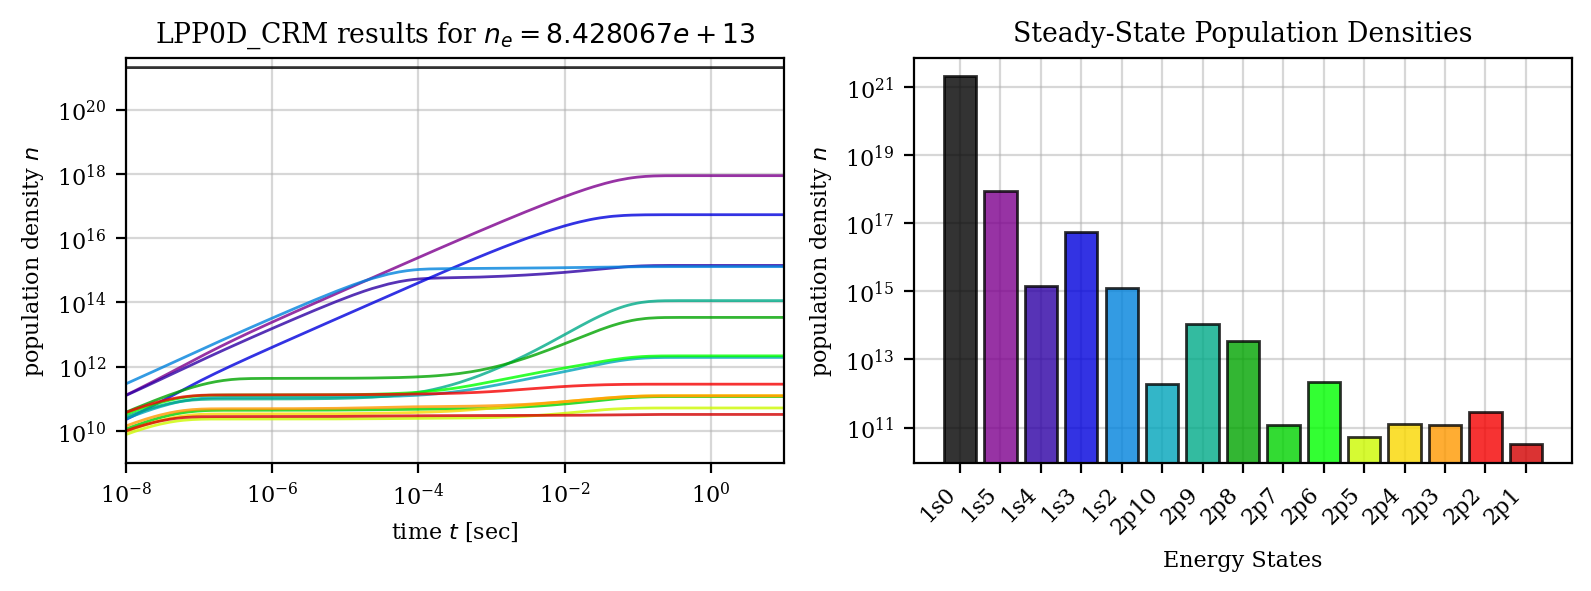

metastable 1s5 density: 4.284e-02 %


In [ ]:
index = -1 # appropriate index to get stable densities

atoms = LPP0D.atomic_data.atoms
masses = LPP0D.masses_dictionary.masses_dictionary
mass_gas = masses['Ar'] * u # in kg

labels = ["1s0", "1s2","1s3","1s4","1s5","2p1","2p2","2p3","2p4", "2p5", "2p6" , "2p7", "2p8", "2p9", "2p10"]

args = {
    "Time" : None ,
    "Te" : None,
    "Ne_t" : lambda t : Ne, 
    "Ng_t" : lambda t : Ng,
    "EDistribution" : distrib ,
    "d" : 0.15,
    "Tg" : 300,
    "Profile" : "Gaussian",
    "Absorption Model" : "Mewe approximation"
}
    
def Run_CRM(Ne,Ng,args,plotting=True):    

    chem = LPP0D.Reactions('Inputs/input_Ar.txt', args)
    LPP0D.gen_diff(input_file= 'Inputs/input_Ar.txt')
    init_vector = np.zeros(16)
    init_vector[0] = Ne
    init_vector[1] =  Ng
    
    time = [0, 1e1]
    time, densities = LPP0D.solve_crm(time, init_vector, chem, 'BDF')
    
    n_i = densities.T
    if plotting:
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), gridspec_kw={'width_ratios': [1, 1]})

        # --- Sort labels and populations by energy ---
        atom_energies = np.array([atoms['Xe']['Levels'][label]['Energy'] for label in labels])
        sorted_indices = np.argsort(atom_energies)  # from low to high energy
        labels_sorted = [labels[i] for i in sorted_indices]
        n_i_sorted = n_i[:, sorted_indices]  # reorder columns of n_i accordingly
        
        # --- Left Plot: Time Evolution ---
        lines = []
        jet_colors = [plt.cm.nipy_spectral(i/15) for i in range(len(labels))]        
        
        for i in range(n_i.shape[1]):
            line, = ax1.plot(time, n_i_sorted[:, i], label=labels_sorted[i],color=jet_colors[i],alpha=.8,lw=1)
            lines.append(line)
        ax1.set_title(f'LPP0D_CRM results for $n_e = {format_e(float(Ne))}$')
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlim(1e-8, 1e1)
        ax1.set_ylim(1e9, 2*n_i.max())
        #ax1.legend(ncol=3,fontsize=4)
        ax1.set_xlabel('time $t$ [sec]')
        ax1.set_ylabel('population density $n$')
        ax1.grid(alpha=0.5, which='major')
        ax1.grid(ls=':', alpha=0.5, which='minor')
        
        # --- Right Plot: Steady-State Bar Chart ---
        ax2.set_axisbelow(True)
        ax2.grid(alpha=0.5, which='major')
        ax2.grid(ls=':', alpha=0.5, which='minor')
        colors = [line.get_color() for line in lines]
        bars = ax2.bar(range(len(labels_sorted)), n_i_sorted[-1], color=colors,edgecolor='k',alpha=.8)
        ax2.set_xticks(range(len(labels_sorted)))
        ax2.set_xticklabels(labels_sorted, rotation=45, ha='right')
        ax2.set_title('Steady-State Population Densities')
        ax2.set_xlabel('Energy States')
        ax2.set_ylabel('population density $n$')
        ax2.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        ax2.set_yscale('log')
        
        
        plt.tight_layout()
        plt.show()
        print('metastable 1s5 density: %.3e'%(n_i[-1][4]/Ng*100),'%')
    return n_i
Ne,Ng = np.mean(np.loadtxt(path+'density.dat')[1]),GAS_DENSITY
n_i = Run_CRM(Ne,Ng,args)

In [ ]:
r = (n_i[-1][4]/GAS_DENSITY)
print('Metastable 1s5 makes up:',r*100,"%")

Metastable 1s5 makes up: 0.04283859536568379 %
